# IMPORTING NECESSARY PACKAGES

In [2]:
import pandas as pd 
from matplotlib import pyplot 
import statsmodels as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics

# IMPORTING THE DATASET
The Dataset contains total of 4 columns. It’s a time series data where the number of deaths, case count, Hospitalized count are matched with the date on which it occurred. The dataset contains data will 2nd of June. 

In [3]:
data = pd.read_csv("Covid_test.csv",parse_dates=True,squeeze=True)

In [4]:
data.head(5)

,DATE,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,02-29-2020,1,14,0
1,03-01-2020,1,4,0
2,03-02-2020,0,23,0
3,03-03-2020,2,22,0
4,03-04-2020,5,22,0


#### CONSIDERING RELEVANT COLUMNS AND DROPPING OTHER COLUMNS

In [5]:
time = data[['DATE','HOSPITALIZED_COUNT']]

In [6]:
print(time.index)

RangeIndex(start=0, stop=90, step=1)


### PLOTTING THE GRAPH FOR DATE AND HOSPITALIZED COUNTS

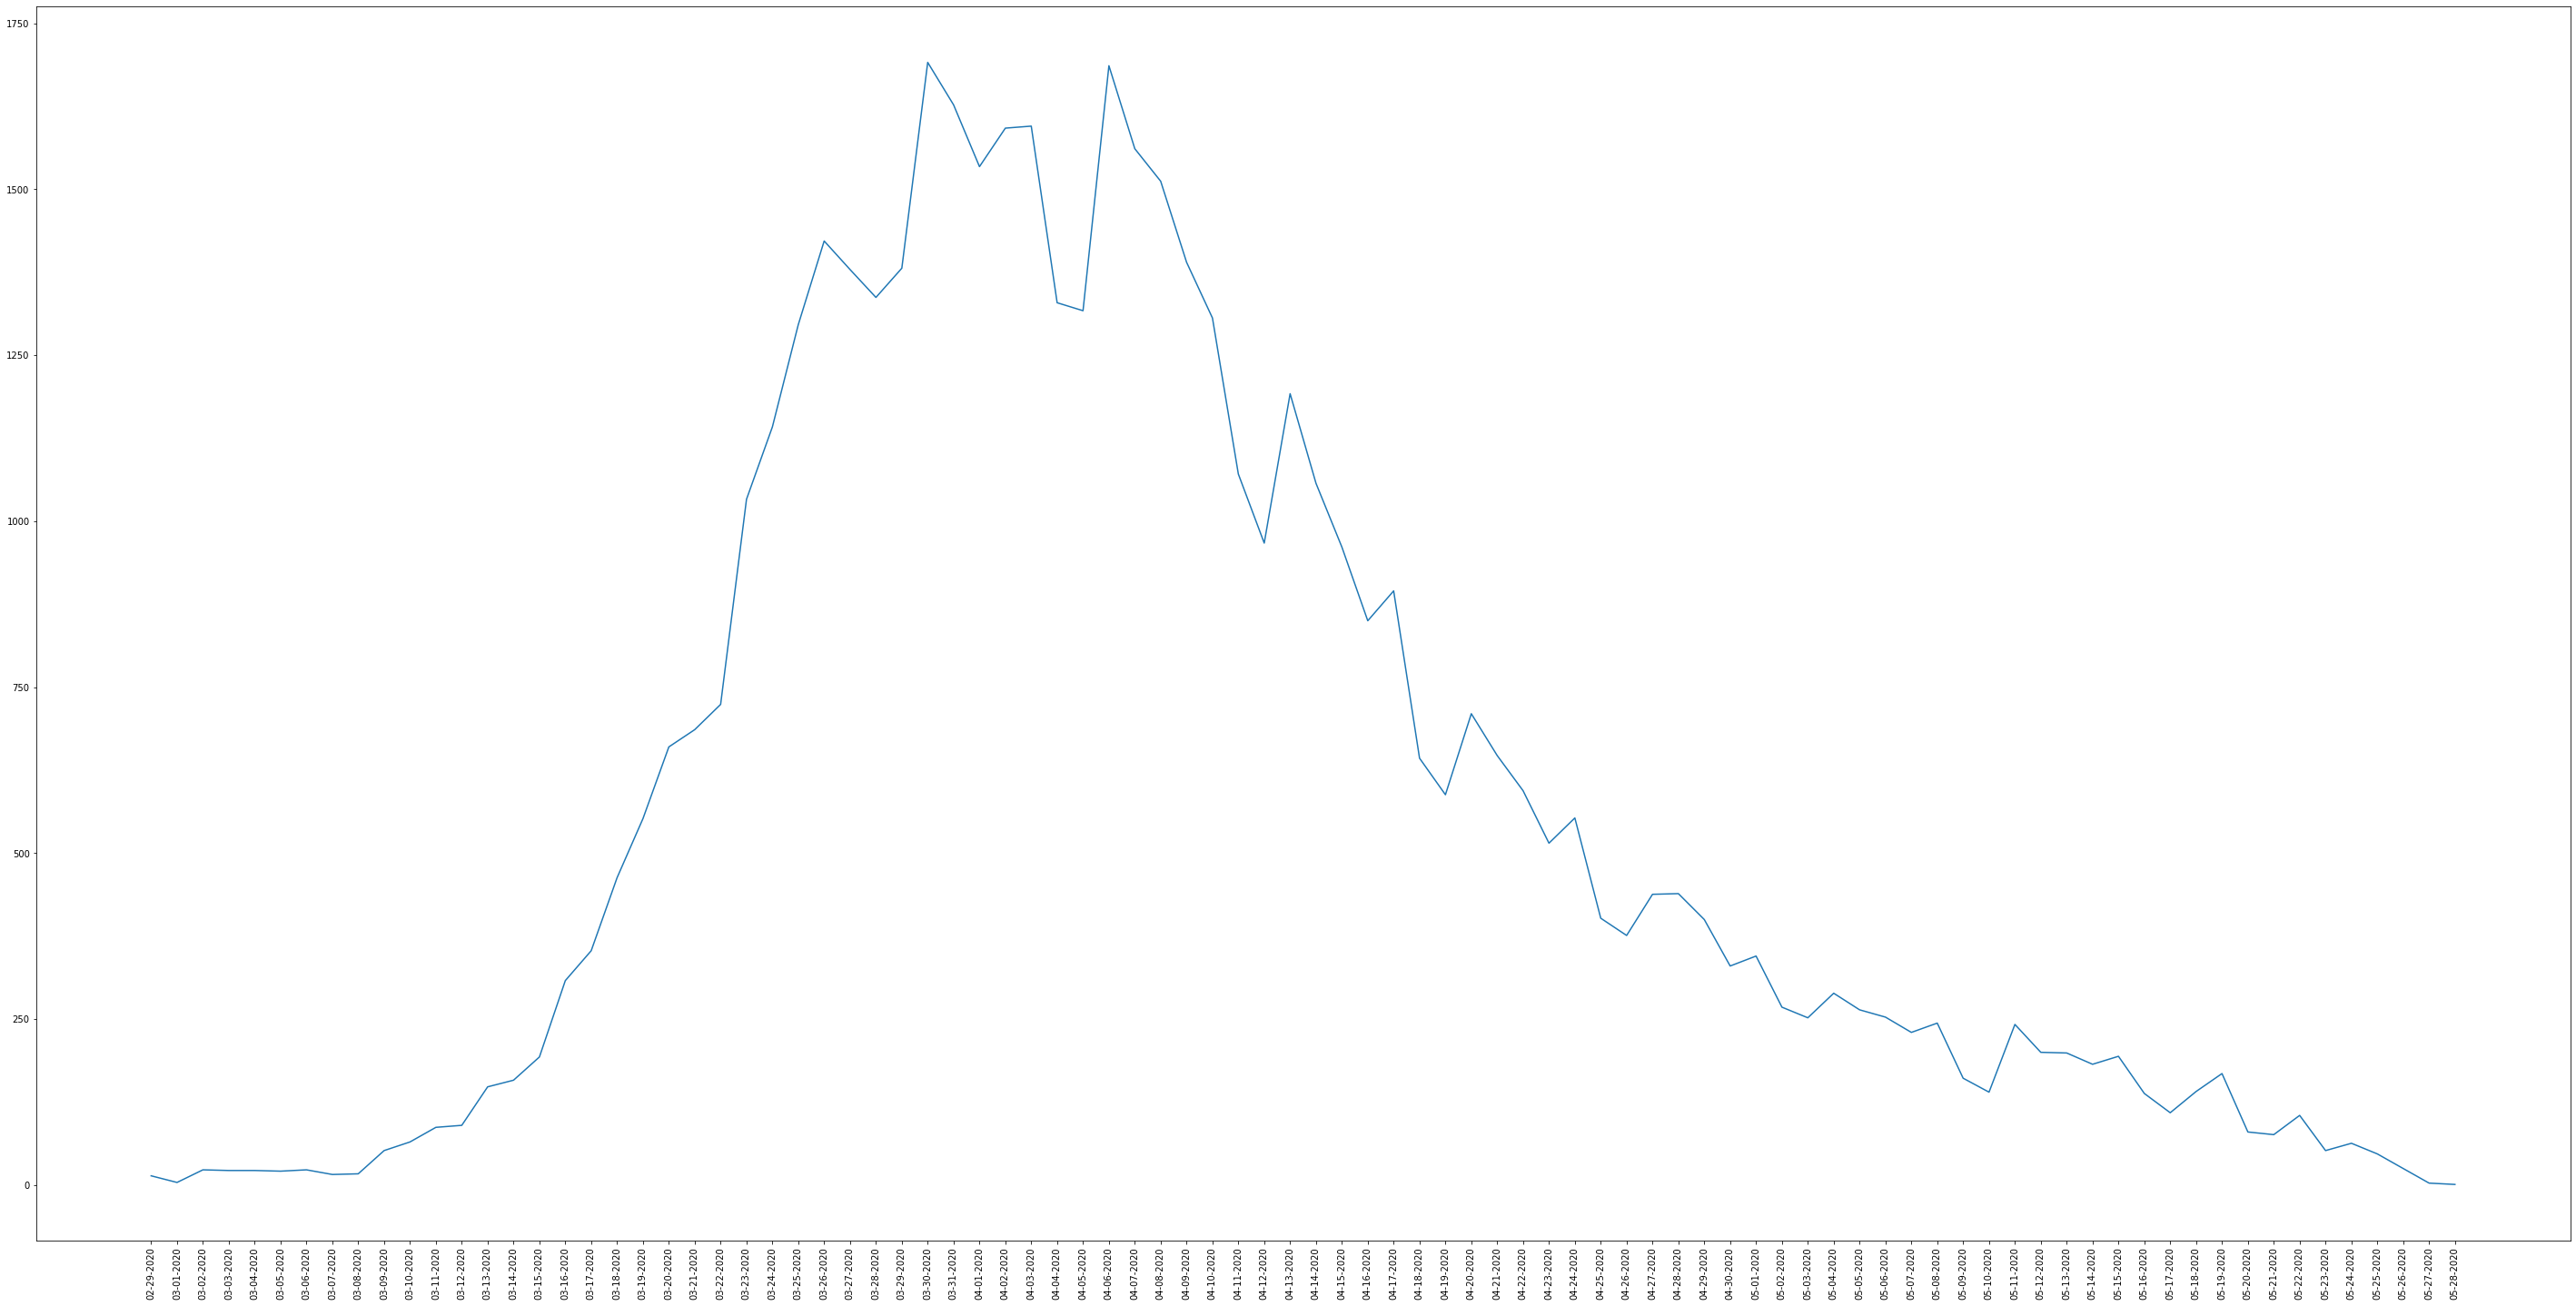

In [22]:
pyplot.plot(time['DATE'],time['HOSPITALIZED_COUNT'])
pyplot.xticks(time['DATE'], rotation='vertical')
pyplot.rcParams['figure.figsize']=(50,40)
pyplot.show()


#### DROPPING DATE COLUMN

In [23]:
final = time['HOSPITALIZED_COUNT']

In [24]:
final.head()

0    14
1     4
2    23
3    22
4    22
Name: HOSPITALIZED_COUNT, dtype: int64

### CALCULATING P-VALUE AND ADF STATISTIC VALUE

In [25]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(final.diff().dropna())
print('ADF Statistic: %f' % result[0])#p value is greater than 0.05 and ADF is greater than critical value, 
print('p-value: %f' % result[1]) #null hypothesis is rejected, data is non-stationary

ADF Statistic: -2.334438
p-value: 0.161101


### PLOTTING REQUIRED GRAPHS FOR DETERMINING THE D VALUE FOR ARIMA MODEL

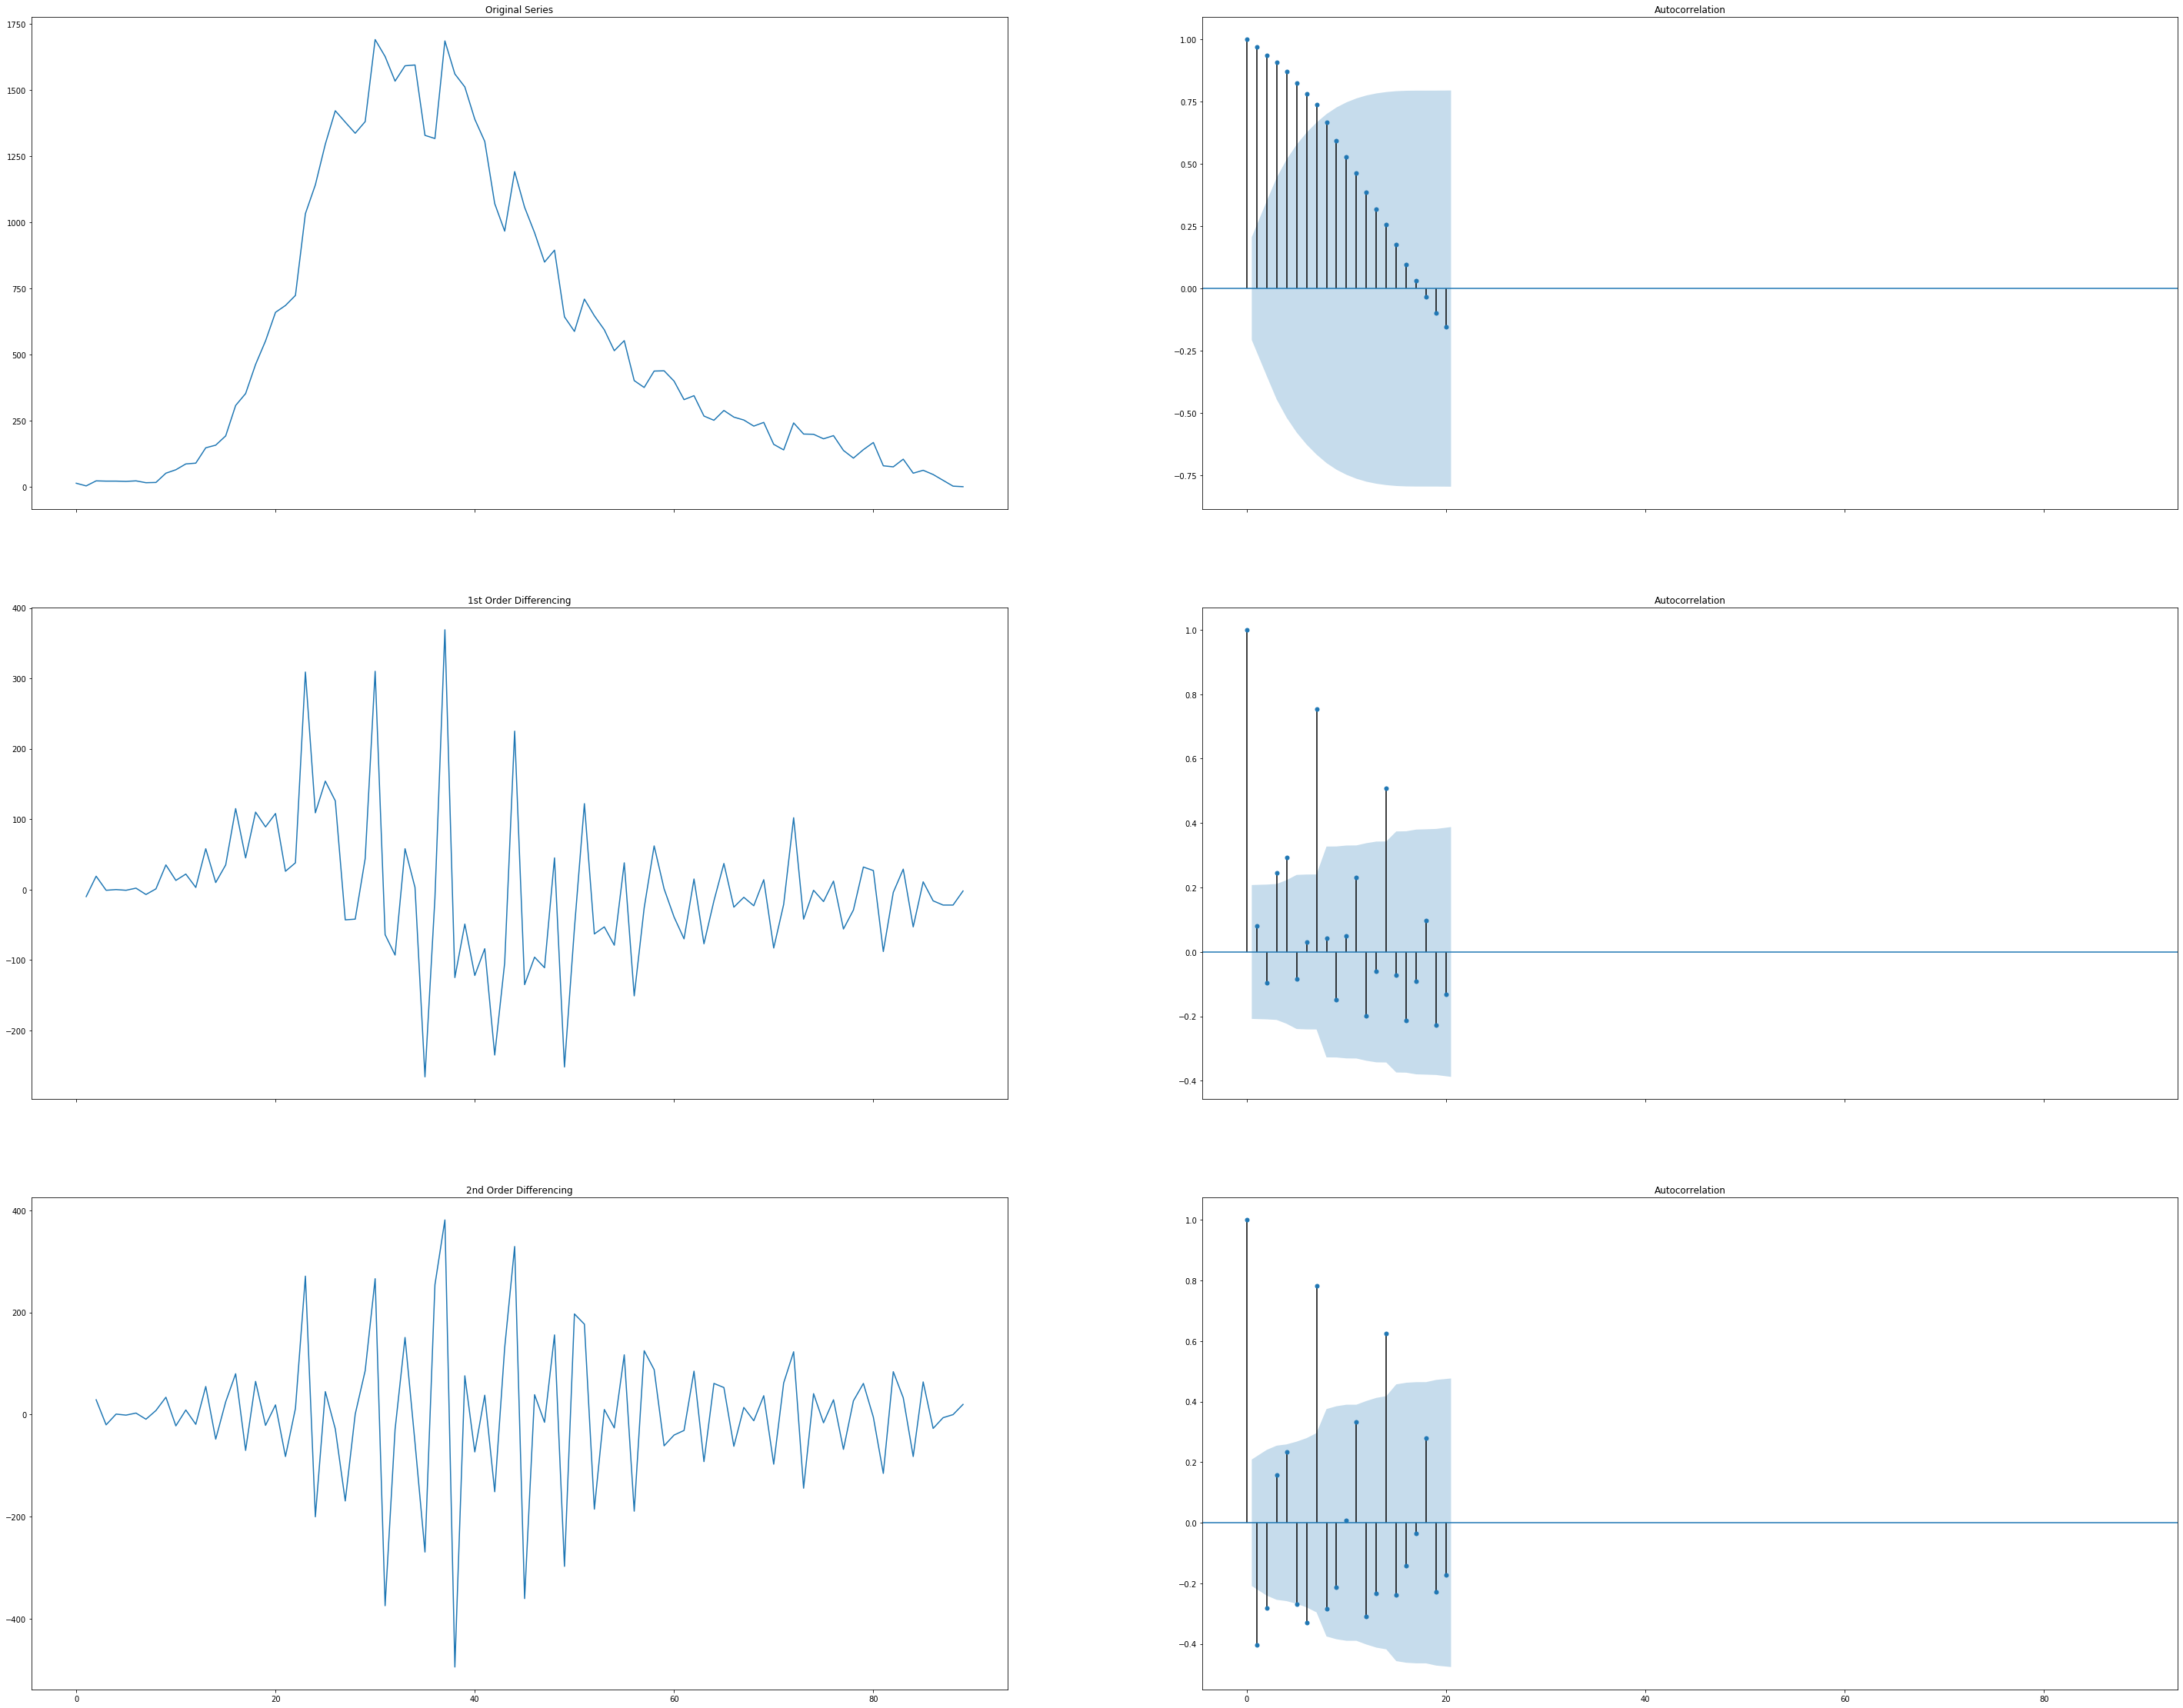

In [26]:
# Original Series
fig, axes = pyplot.subplots(3, 2, sharex=True)
axes[0, 0].plot(final); axes[0, 0].set_title('Original Series')
plot_acf(final, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(final.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(final.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(final.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(final.diff().diff().dropna(), ax=axes[2, 1])
pyplot.rcParams['figure.figsize']=(10,20)
pyplot.show()

### DIFFERENCING TO MAKE DATA STATIONARY AND DETERMINING THE Q VALUE FOR THE MODEL 

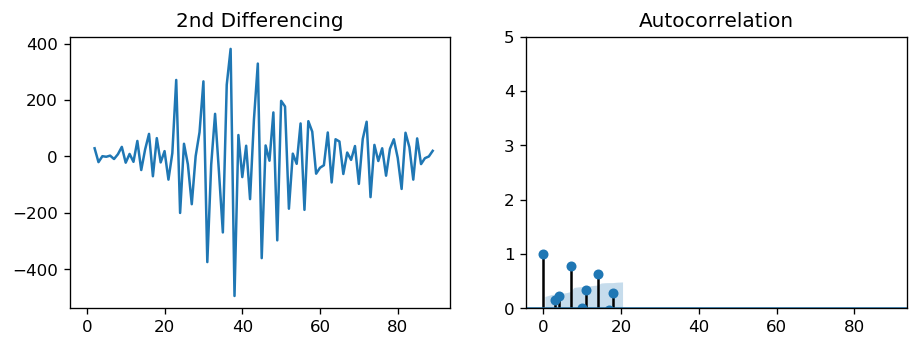

In [29]:
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = pyplot.subplots(1, 2, sharex=True)
axes[0].plot(final.diff().diff()); axes[0].set_title('2nd Differencing')#implementing first order differencing
axes[1].set(ylim=(0,5))
plot_acf(final.diff().diff().dropna(), ax=axes[1])

pyplot.show()

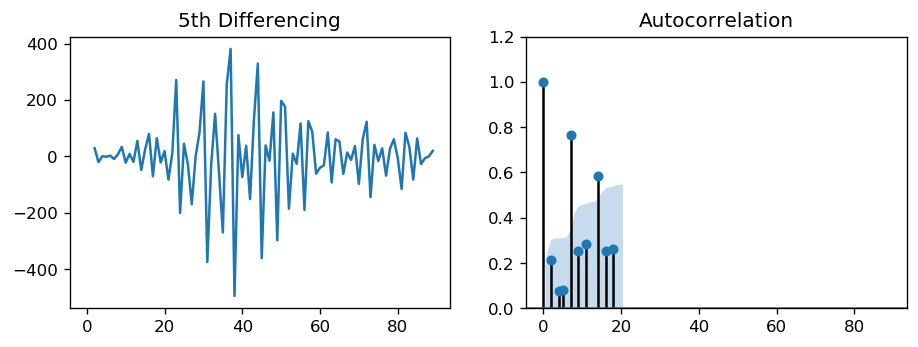

In [30]:

### TO DETERMINE THE Q VALUE FOR THE ARIMA MODEL 

pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = pyplot.subplots(1, 2, sharex=True)
axes[0].plot(final.diff().diff()); axes[0].set_title('5th Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(final.diff().diff().diff().diff().diff().dropna(), ax=axes[1])
pyplot.show()

### SPLITTING THE DATASET IN TRAIN AND TEST

In [31]:
train = final[:38]

In [32]:
test = final[38:48]

In [33]:
import numpy as np

### STORING THE FINAL VALUES IN ARRAY FORMAT

In [34]:
test1 = np.asarray(test)

In [35]:
test.describe()

count      10.000000
mean     1186.700000
std       245.921419
min       850.000000
25%       989.500000
50%      1131.500000
75%      1369.000000
max      1561.000000
Name: HOSPITALIZED_COUNT, dtype: float64

In [36]:
test.tail()

43     967
44    1192
45    1057
46     961
47     850
Name: HOSPITALIZED_COUNT, dtype: int64

### BUILDING AN ARIMA MODEL
### Time Series Analysis:Time series data is a data which includes inputs changing with respect to time. In Time series there are dependent variables and independent variables. In this assignment Time is the independent variable. The main aim of the project is to forecast the values for the next 10 days. It is mainly used for short period forecasting. The minimum required data points are 40. The model can perform in best circumstances when there is a consistent growth in the data and we have fewer outliers.

In [37]:
model = ARIMA(train, order=(5, 0, 1)) #p,d,q values are given as 5,0,1 respectively. 
fitted = model.fit(disp=False) 

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### FORECASTING THE VALUES FOR THE NEXT 10 DAYS

In [38]:
# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% confidence interval

In [39]:
val = pd.DataFrame(fc,index=['1','2','3','4','5','6','7','8','9','10'],columns=['a'])

In [40]:
val['b']=test1

### FETCHING THE TABLE FOR ACTUAL VALUES AND PREDICTED VALUES

In [41]:
val

,a,b
1,1621.726438,1561
2,1345.755729,1512
3,1354.604730,1390
4,1437.138531,1306
5,1318.243175,1071
6,1173.327334,967
7,1147.841587,1192
8,1111.339382,1057
9,994.919422,961
10,892.067765,850


### PLOTTING THE GRAPH FOR ACTUAL VS THE PREDICTED USING MEAN SQUARE ERROR FUNCTION

Test MSE: 16129.811


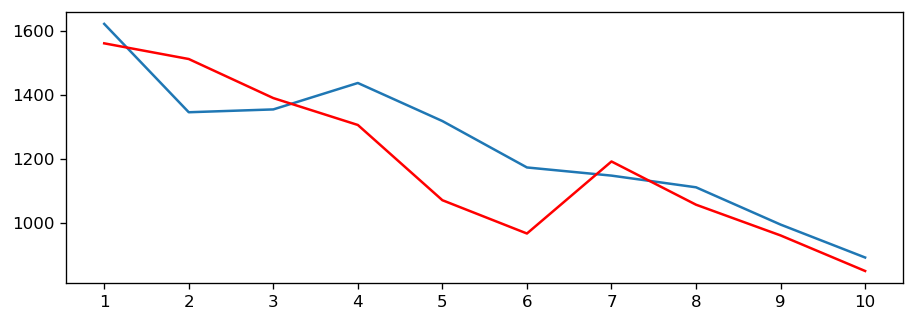

In [49]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(val['a'],val['b'])
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(val['a'])
pyplot.plot(val['b'], color='red')
pyplot.show()


### PLOTTING THE GRAPH FOR ACTUAL VS FORECAST VALUES FOR TRAINING, ACTUAL, FORECAST TYPES

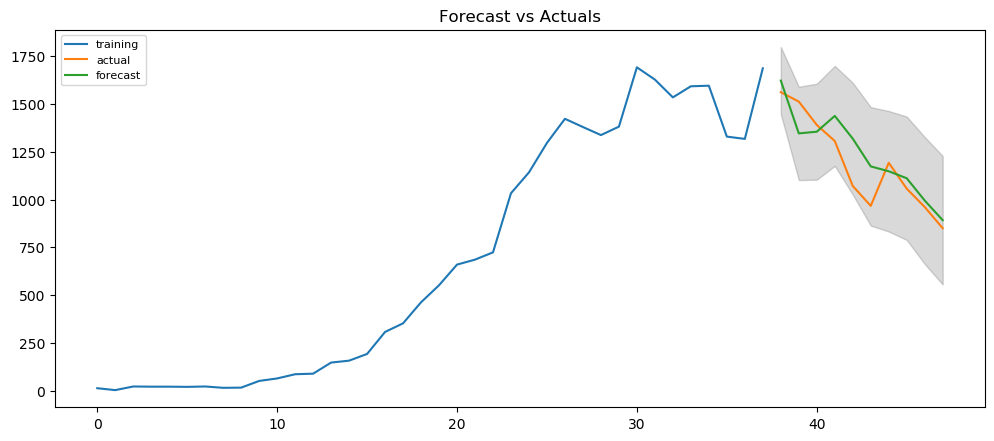

In [48]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
pyplot.figure(figsize=(12,5), dpi=100)
pyplot.plot(train, label='training')
pyplot.plot(test, label='actual')
pyplot.plot(fc_series, label='forecast')
pyplot.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
pyplot.title('Forecast vs Actuals')
pyplot.legend(loc='upper left', fontsize=8)
pyplot.show()
